In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
from itertools import combinations
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Statevector
from tabulate import tabulate
from itertools import combinations
from qiskit.circuit.library import EfficientSU2
import math
import time
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit.algorithms import TimeEvolutionProblem
from qiskit.algorithms import VarQITE
from qiskit.primitives import Estimator
from qiskit.quantum_info import Statevector
from qiskit.algorithms import SciPyImaginaryEvolver
import pylab
from qiskit.algorithms.gradients import ReverseEstimatorGradient, ReverseQGT
from qiskit.circuit.library import RYGate
import matplotlib.pyplot as plt

import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from scipy.linalg import eigh, block_diag
import matplotlib.gridspec as gridspec

In [111]:
def spinless_sub_dim(N,r) : 
    '''
    input : number of lattice sites (N), number of electrons (r) 
    output : dimension of this subspace 
    '''
    return math.comb(N,r)

def spinless_basis(N,r) : 
    basis_set = []
    lattice = list(range(N))
    places = list(combinations(lattice, r))
    for combination in places : 
        basis = [False] *N
        for index in combination : 
            basis[index] = True 
        basis_set.append(basis)
    return basis_set

def hubb0_model(N,r,e,t,U): 
    ''' Generalised Tight Binding (spinless) model for periodic boundary condition
    Input : Number of lattice sites (int), number of electrons(int), hopping constant (int/float), onsite energies (list), interaction term U (int)
    Output : Tight binding Hamiltonian, eigenvalues and eigenvectors of the matrix ''' 
    dim = spinless_sub_dim(N,r)
    #Special Cases
    if r==0 : 
        H = np.zeros(1)
        eigval = 0
        new_vec = [[1]]
    elif r==N : 
        H = [[sum(e)+N*U]]
        eigval = H[0]
        new_vec = [[1]]
    if N == 1 and r==1: 
        H = [e]
        eigval = H[0]
        new_vec = [[1]]
    else : 
        H = np.zeros((dim, dim))
        basis_set = spinless_basis(N,r)
        #H_diagonal, onsite energy terms
        n_diag = np.zeros(dim)
        for i in range(dim) : 
            for j in range(N) : 
                n_diag[i] += e[j]*basis_set[i][j]
        np.fill_diagonal(H,n_diag)
        #H_T Hopping terms 
        for basis_index,basis in enumerate(basis_set) : 
            for site in range(len(basis)) : 
                if basis[site] == False and basis[(site+1)%N] == True : 
                    new_state = basis.copy()
                    new_state[site] = True
                    new_state[(site+1)%N] = False 
                    for i in range(len(basis_set)) : 
                        if basis_set[i] == new_state: 
                            f_index = i
                    H[f_index][basis_index] +=t
                if N != 2 : 
                    if basis[site] == True and basis[(site+1)%N] == False : 
                        new_state = basis.copy()
                        new_state[site] = False
                        new_state[(site+1)%N] = True 
                        for i in range(len(basis_set)) : 
                            if basis_set[i] == new_state : 
                                f_index = i
                        H[f_index][basis_index] +=t 
        #H_U, interaction terms
        for basis_index,basis in enumerate(basis_set) : 
            for site in range(len(basis)) : 
                if basis[site] == True and basis[(site+1)%N] == True : 
                    H[basis_index][basis_index] +=U

        eigval,eigvec = np.linalg.eigh(H)
        new_vec = list(zip(*eigvec))                   
    return H,eigval,new_vec

def hubb0_JW(N,e,t,U) : 
    strings = []
    opt = SparsePauliOp.from_sparse_list([("I", [0], 0)], num_qubits=N)  
    for k in range(N) : 
        a0='I'*N
        a1 = 'I'*(k)+'Z' +'I'*(N-k-1)

        b0='I'*N
        b0_list = list(b0)
        b0_list[k] = 'X'
        b0_list[(k+1)%N] = 'X'
        new_b0 = ''.join(b0_list)

        b1='I'*N
        b1_list = list(b0)
        b1_list[k] = 'Y'
        b1_list[(k+1)%N] = 'Y'
        new_b1 = ''.join(b1_list)
        
        c_base='I'*N

        c0 = c_base
        
        c1_list = list(c_base)
        c1_list[k] = 'I'
        c1_list[(k+1)%N] = 'Z'
        c1 = ''.join(c1_list)
        
        c2_list = list(c_base)
        c2_list[k] = 'Z'
        c2_list[(k+1)%N] = 'I'
        c2 = ''.join(c2_list)
        
        c3_list = list(c_base)
        c3_list[k] = 'Z'
        c3_list[(k+1)%N] = 'Z'
        c3 = ''.join(c3_list)
        T=t
        if N==2 : 
            T=t/2
        
        opt += SparsePauliOp.from_list([(a0, 0.5*e[k]), (a1, -0.5*e[k]),
                                        (new_b0, 0.5*T),(new_b1, 0.5*T),
                                        (c0, U*0.25),(c1, -0.25*U),(c2, -0.25*U),(c3,U*0.25)])
    return opt

In [112]:
path01 = "U0.csv"
path02 = "U1.csv"
path03="U4.csv"


df01 = pd.read_csv(path01)
df02 = pd.read_csv(path02)
df03 = pd.read_csv(path03)


df_list = [df01,df02,df03]

In [108]:
# U = [0,1,4]

# for ind,df in enumerate(df_list) : 
#     fig = plt.figure(figsize=(18, 4))
#     gs = gridspec.GridSpec(1, 3, width_ratios=[4, 1, 1])
    
#     eig_c = df['eig_c']
#     eig_q = df['eig_q']
#     eig_true = df['eig_true']
#     N = df['N']
#     #xticks = [0,1,3,6,10,15]
    

#     comb = []
#     for num in df['N'].unique() : 
#         sub_list = [f'{num}C{i}' for i in range(1,num)]
#         comb += sub_list
#     #xtick_labels = [comb[i] for i in xticks]
#     time_c = df['time_clas']
#     time_q = df['time_q']
    
#     axs0 = plt.subplot(gs[0])
#     axs0.plot(comb, eig_c, label='Classical eig', color='orange', marker='o')
#     axs0.plot(comb, eig_q, label='VarQITE eig', color='blue',marker='o')
#     axs0.plot(comb, eig_true, label='True eig', color='red',linestyle='--')
#     axs0.plot
#     axs0.set_xlabel('Number of qubits')
#     axs0.set_ylabel('Eigenvalue')
#     axs0.set_title(f'Estimated eigenvalue for different subspaces, U={U[ind]}')
#     axs0.grid(True)
# #     axs0.set_xticks(xticks)
# #     axs0.set_xticklabels(xtick_labels)
#     axs0.legend()
    
#     colors = ['green', 'yellow']
#     partitions = [0,1,3,6,10,15,21,28]
#     #partitions = [p-1 for p in partitions]
#     for a in partitions:
#         plt.axvline(x=a, color='gray', alpha=0.7)
#     for i in range(1,7) : 
#         axs0.axvspan(partitions[i], partitions[i+1]-1, facecolor=colors[i%2], alpha=0.2)

# #     for i in range(len(partitions)):
# #         axs0.plot(x_values[i:i+2], y_values[i:i+2], linestyle='none', marker='o', markersize=8)

#     plt.tight_layout()
#     plt.show()

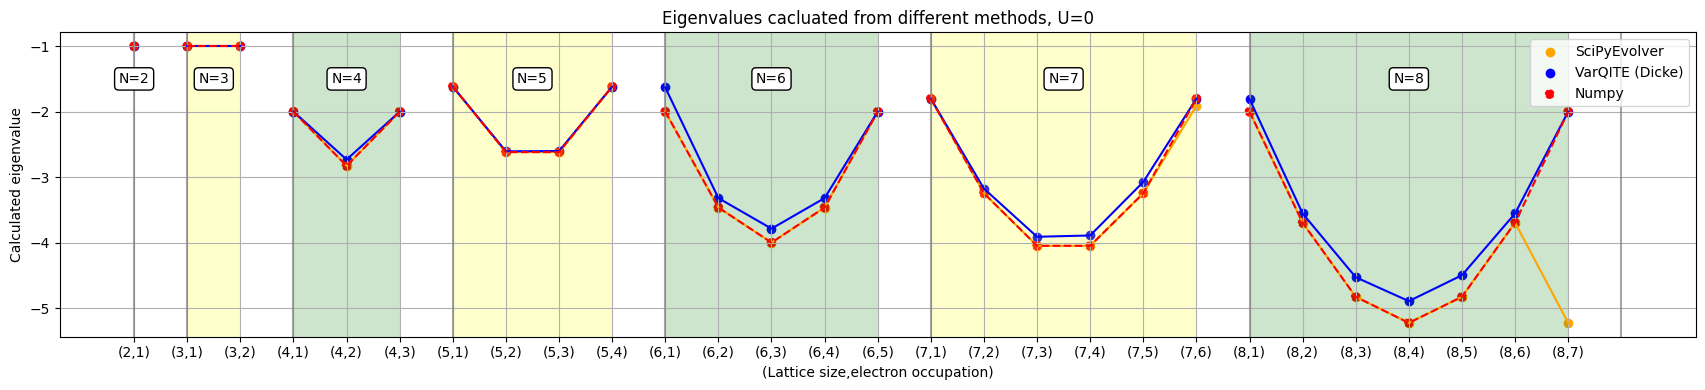

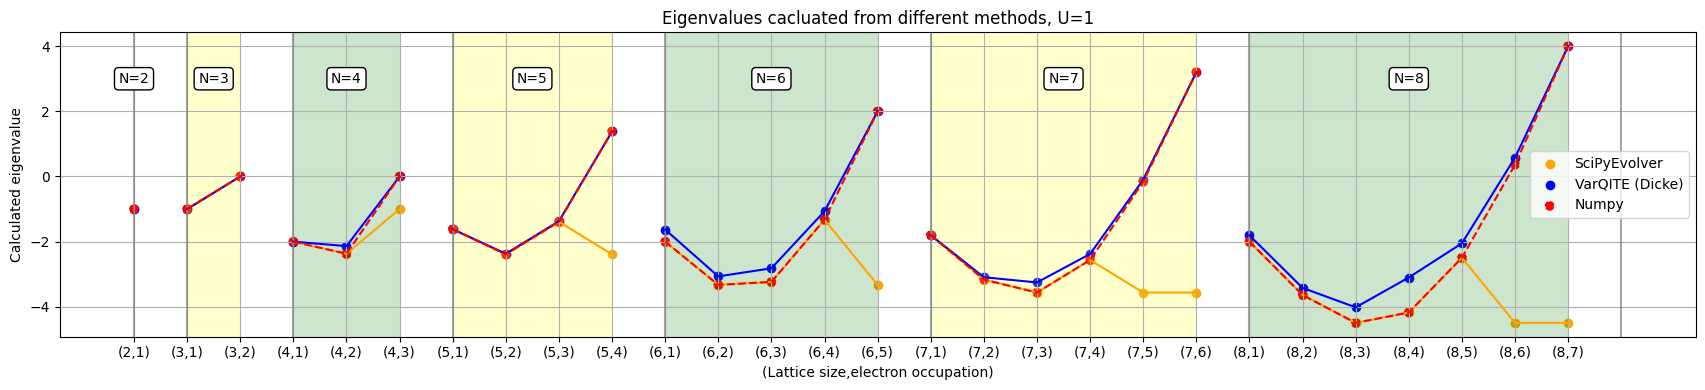

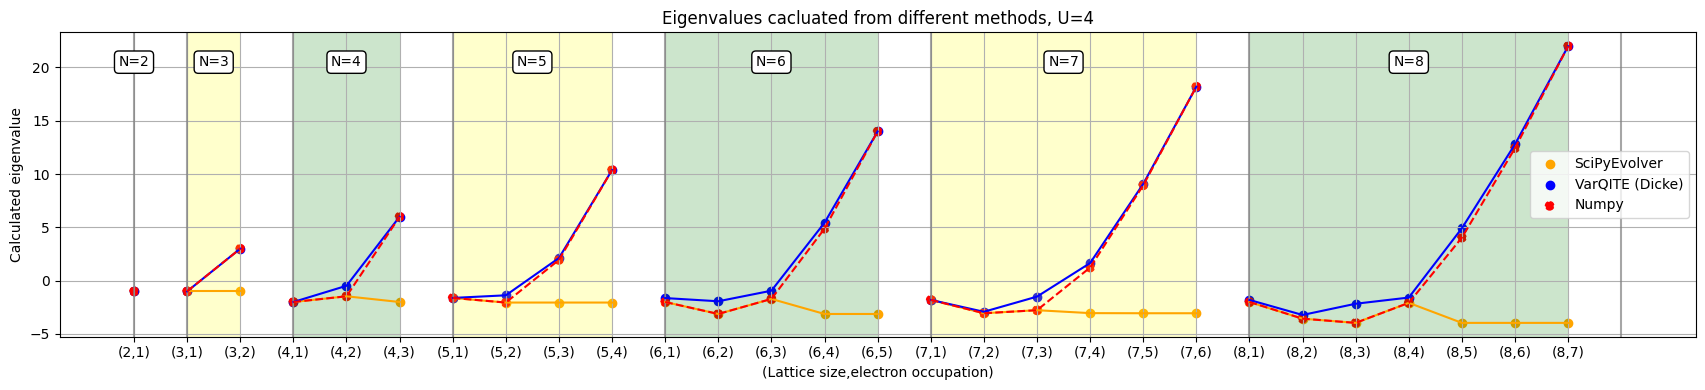

In [85]:
U = [0,1,4]

for ind,df in enumerate(df_list) : 
    fig = plt.figure(figsize=(24, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[5, 1, 1])
    
    eig_c = df['eig_c']
    eig_q = df['eig_q']
    eig_true = df['eig_true']
    N = df['N']
    #xticks = [0,1,3,6,10,15]
    

    comb = []
    for num in df['N'].unique() : 
        sub_list = [f'({num},{i})' for i in range(1,num)]
        comb += sub_list
    #xtick_labels = [comb[i] for i in xticks]
    time_c = df['time_clas']
    time_q = df['time_q']
    
    axs0 = plt.subplot(gs[0])
    axs0.scatter(comb, eig_c, label='SciPyEvolver', color='orange', marker='o')
    axs0.scatter(comb, eig_q, label='VarQITE (Dicke)', color='blue',marker='o')
    axs0.scatter(comb, eig_true, label='Numpy', color='red',linestyle='--')
    axs0.plot
    axs0.set_xlabel('(Lattice size,electron occupation)')
    axs0.set_ylabel('Calculated eigenvalue')
    axs0.set_title(f'Eigenvalues cacluated from different methods, U={U[ind]}')
    axs0.grid(True)
#     axs0.set_xticks(xticks)
#     axs0.set_xticklabels(xtick_labels)
    
    colors = ['green', 'yellow']
    partitions = [0,1,3,6,10,15,21,28]
    #partitions = [p-1 for p in partitions]
    for a in partitions:
        plt.axvline(x=a, color='gray', alpha=0.7)
    for i in range(1,len(partitions)-1) : 
        axs0.axvspan(partitions[i], partitions[i+1]-1, facecolor=colors[i%2], alpha=0.2)
        axs0.plot(comb[partitions[i]:partitions[i+1]], eig_c[partitions[i]:partitions[i+1]], color='orange')
        axs0.plot(comb[partitions[i]:partitions[i+1]], eig_q[partitions[i]:partitions[i+1]],color='blue')
        axs0.plot(comb[partitions[i]:partitions[i+1]], eig_true[partitions[i]:partitions[i+1]],color='red',linestyle='--')
    labels = [f'N={n}' for n in N.unique()]
    label_coords = []
    x = 0
    for i,n in enumerate(N.unique()) : 
        label_coords.append((partitions[i] + (n)/2-1 ,max(eig_q)-0.5*(ind+1)))
    #print(label_coords)
    for label, (x_coord, y_coord) in zip(labels, label_coords):
        axs0.text(x_coord, y_coord, label, fontsize=10, ha='center', va='center', color='black', 
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

#     for i in range(1,len(partitions)):
#         axs0.plot(partitions[i:1+i], y_values[i:i+2], linestyle='none', marker='o', markersize=8)
    axs0.legend(loc='best')
    plt.tight_layout()
    plt.show()

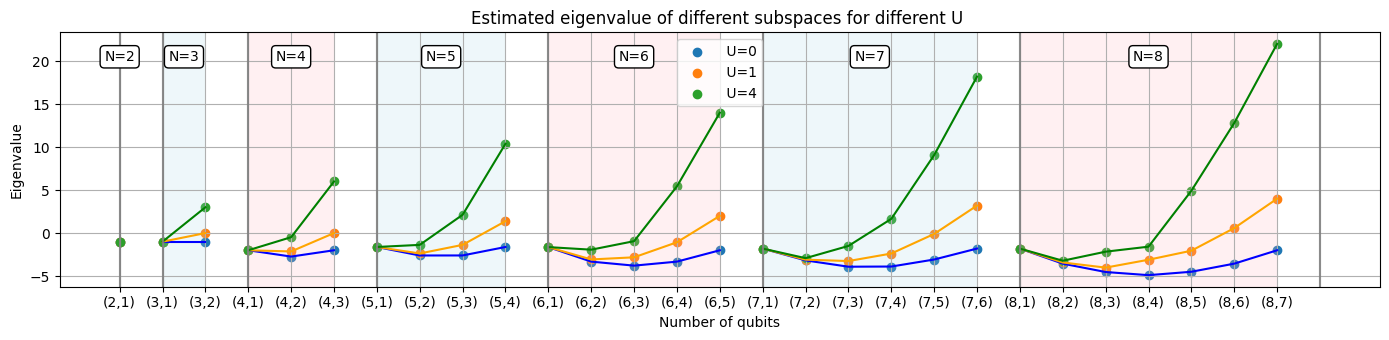

In [104]:
U = [0,1,4]
partitions = [0,1,3,6,10,15,21,28]
plt.figure(figsize=(14, 3.5))
col = ['blue','orange','green']
eigq_list = [df['eig_q'] for df in df_list]
#print(eigq_list)
for idx,eig_q in enumerate(eigq_list) : 

    N = df['N']
    #xticks = [0,1,3,6,10,15]
    

    comb = []
    for num in df['N'].unique() : 
        sub_list = [f'({num},{i})' for i in range(1,num)]
        comb += sub_list

    #plt.plot(comb, eig_c, label='Classical eig', color='orange', marker='o')
    plt.scatter(comb, eig_q, label=f' U={U[idx]}',marker='o')
    for i in range(1,len(partitions)-1) : 
        plt.plot(comb[partitions[i]:partitions[i+1]], eig_q[partitions[i]:partitions[i+1]], 
                 color=col[idx])
    
    #axs0.plot(comb, eig_true, label='True eig', color='red',linestyle='--')
    
for a in partitions:
    plt.axvline(x=a, color='gray', alpha=0.7)

plt.xlabel('Number of qubits')
plt.ylabel('Eigenvalue')
plt.title(f'Estimated eigenvalue of different subspaces for different U ')
plt.grid(True)
#     axs0.set_xticks(xticks)
#     axs0.set_xticklabels(xtick_labels)

colors = ['lightpink', 'lightblue']
partitions = [0,1,3,6,10,15,21,28]

for a in partitions:
    plt.axvline(x=a, color='gray', alpha=0.7)
for i in range(1,len(partitions)-1) : 
    plt.axvspan(partitions[i], partitions[i+1]-1, facecolor=colors[i%2], alpha=0.2)

labels = [f'N={n}' for n in N.unique()]
label_coords = []
x = 0
for i,n in enumerate(N.unique()) : 
    label_coords.append((partitions[i] + (n)/2-1 ,max(eig_q)-0.5*(ind+1)))
#print(label_coords)
for label, (x_coord, y_coord) in zip(labels, label_coords):
    plt.text(x_coord, y_coord, label, fontsize=10, ha='center', va='center', color='black', 
              bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

#     for i in range(1,len(partitions)):
#         axs0.plot(partitions[i:1+i], y_values[i:i+2], linestyle='none', marker='o', markersize=8)
plt.legend(loc='best')
plt.tight_layout()

plt.show()

In [17]:
var=0
for N in range(2,9) : 
    print(f'N={N}')
    e = [0]*N
    t=1
    U=0
    e_sub_dict = {}
    for r in range(1,N) : 
        H_sub, e_sub, v_sub = hubb0_model(N,r,e,t,U)
        e_sub_dict[r] = min(e_sub)
    print(e_sub_dict)
    H_jw = hubb0_JW(N,e,t,U)
    
    e_jw,vec = np.linalg.eigh(H_jw.to_matrix())
    v_jw = list(zip(*vec))
    jw_dict = {}
    for i in range(len(e_jw)) : 
        jw_dict[e_jw[i]] = v_jw
    
    states_jw_sub_min = []
    for ex in e_sub_dict.values() : 
        for ej in e_jw : 
            if np.round(ex,2) == np.round(ej,2) : 
                states_jw_sub_min.append(jw_dict[ej])
    print(e_jw)   
    #print(states_jw_sub_min)
    print(len(states_jw_sub_min))
    print('----')

N=2
{1: -1.0}
[-1.  0.  0.  1.]
1
----
N=3
{1: -1.0000000000000004, 2: -1.0000000000000004}
[-1. -1. -1. -1.  0.  0.  2.  2.]
8
----
N=4
{1: -2.0, 2: -2.82842712474619, 3: -2.0}
[-2.82842712e+00 -2.00000000e+00 -2.00000000e+00 -4.51028104e-17
 -1.94358444e-17  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.94513211e-17
  4.82700445e-16  2.00000000e+00  2.00000000e+00  2.82842712e+00]
5
----
N=5
{1: -1.6180339887498953, 2: -2.6180339887498953, 3: -2.6180339887498953, 4: -1.6180339887498953}
[-2.61803399 -2.61803399 -2.61803399 -2.61803399 -1.61803399 -1.61803399
 -1.61803399 -1.61803399 -1.23606798 -1.23606798 -0.38196601 -0.38196601
 -0.38196601 -0.38196601  0.          0.          0.61803399  0.61803399
  0.61803399  0.61803399  1.          1.          1.          1.
  1.          1.          1.          1.          2.          2.
  3.23606798  3.23606798]
16
----
N=6
{1: -2.0, 2: -3.4641016151377535, 3: -4.0, 4: -3.4641016151377544,

In [18]:
np.round(-5.226251859505504,3)

-5.226

In [19]:
np.round(-5.22625186e+00,3)

-5.226

In [20]:
df01['state_est']

0                     [0j, (-0.707+0j), (0.707+0j), 0j]
1     [0j, (-0.493+0j), (-0.317+0j), 0j, (0.81+0j), ...
2     [(-0+0j), 0j, 0j, (-0.28+0j), 0j, (-0.525+0j),...
3     [0j, (-0.5+0j), (0.5+0j), 0j, (-0.5+0j), 0j, 0...
4     [(-0+0j), 0j, 0j, (0.325+0j), 0j, (-0.444+0j),...
5     [0j, 0j, (-0+0j), 0j, (-0+0j), 0j, 0j, (-0.5+0...
6     [0j, (-0.25+0j), (-0.139+0j), 0j, (0.475+0j), ...
7     [(-0+0j), 0j, 0j, (0.075+0j), 0j, (0.212+0j), ...
8     [0j, 0j, (-0+0j), 0j, 0j, 0j, 0j, (0.045+0j), ...
9     [(-0+0j), 0j, 0j, 0j, 0j, 0j, (-0+0j), 0j, 0j,...
10    [0j, (0.041+0j), (0.075+0j), 0j, (-0.421+0j), ...
11    [(-0+0j), 0j, 0j, (0.153+0j), 0j, (-0.194+0j),...
12    [0j, (-0+0j), (-0+0j), 0j, 0j, 0j, 0j, (-0.11+...
13    [(-0+0j), 0j, 0j, (-0+0j), 0j, 0j, (-0+0j), 0j...
14    [0j, 0j, (-0+0j), 0j, (-0+0j), 0j, 0j, 0j, 0j,...
15    [0j, (-0.154+0j), (-0.084+0j), 0j, (0.304+0j),...
16    [0j, 0j, 0j, (-0.015+0j), 0j, (0.015+0j), (-0....
17    [0j, (-0+0j), 0j, 0j, (-0+0j), 0j, 0j, (-0

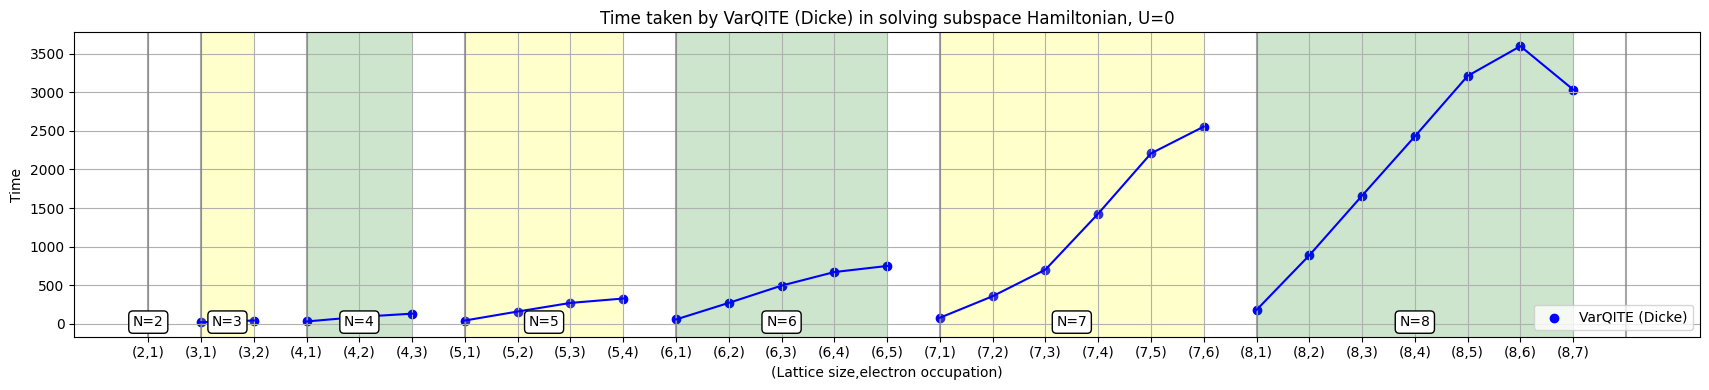

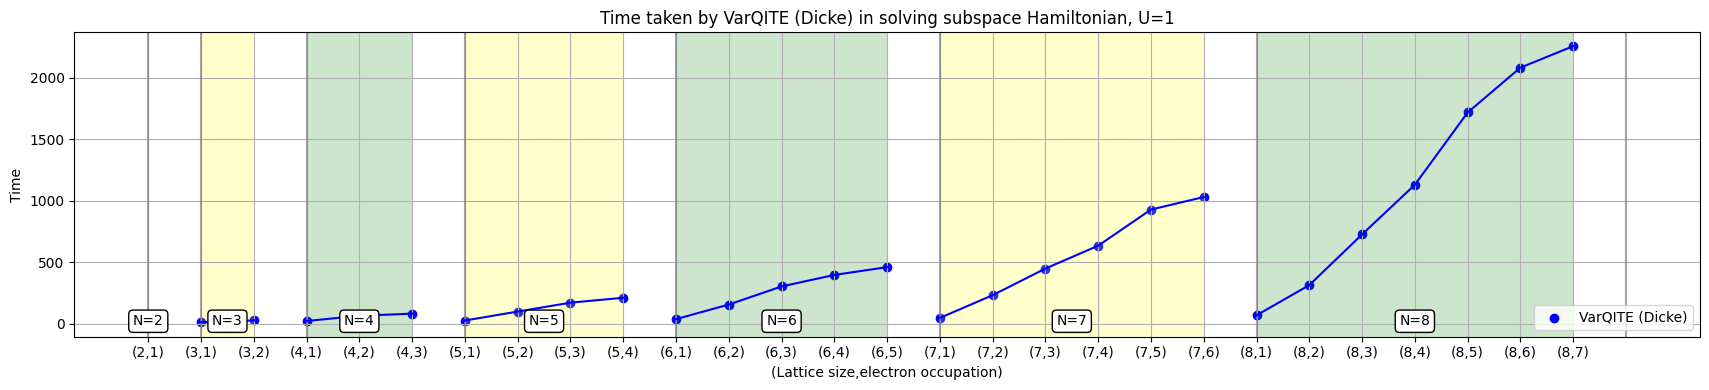

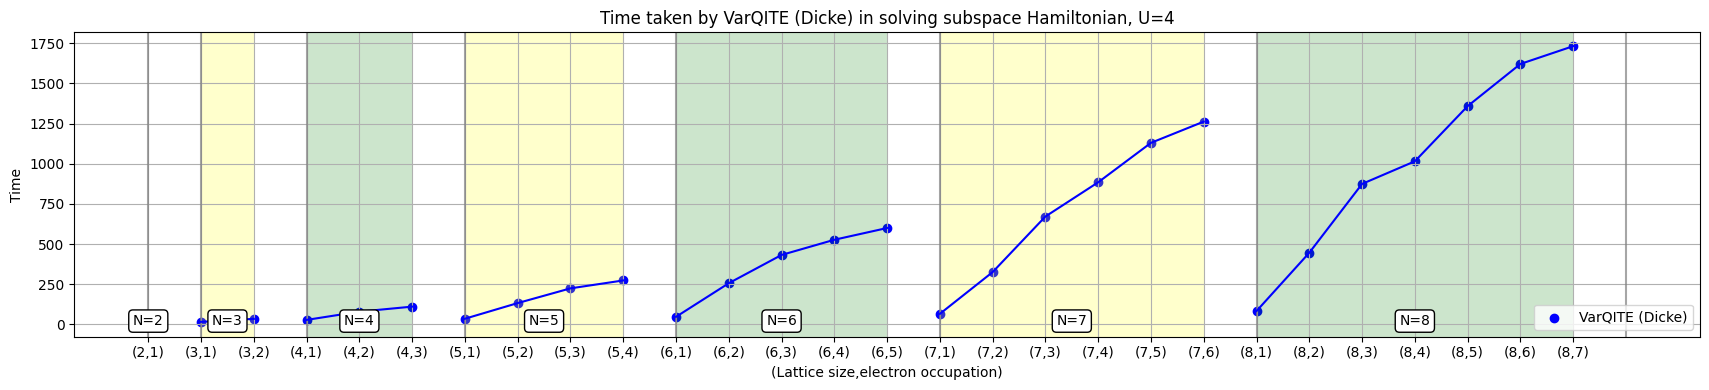

In [120]:
U = [0,1,4]

for ind,df in enumerate(df_list) : 
    fig = plt.figure(figsize=(24, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[5, 1, 1])

    time_q = df['time_q']
    #eig_true = df['eig_true']
    N = df['N']
    #xticks = [0,1,3,6,10,15]
    num_param = []
    for n in N.unique() : 
        for k in range(1,n) : 
            num_param.append(int(k*(n-k) + k*(k-1)/2))

    comb = []
    for num in df['N'].unique() : 
        sub_list = [f'({num},{i})' for i in range(1,num)]
        comb += sub_list
    #xtick_labels = [comb[i] for i in xticks]
    time_c = df['time_clas']
    time_q = df['time_q']
    
    axs0 = plt.subplot(gs[0])
    axs0.scatter(comb, time_q, label='VarQITE (Dicke)', color='blue', marker='o')
    #axs0.scatter(comb, num_param, label='Number of parameters', color='orange', marker='o')

    axs0.plot
    axs0.set_xlabel('(Lattice size,electron occupation)')
    axs0.set_ylabel('Time')
    axs0.set_title(f'Time taken by VarQITE (Dicke) in solving subspace Hamiltonian, U={U[ind]}')
    axs0.grid(True)
#     axs0.set_xticks(xticks)
#     axs0.set_xticklabels(xtick_labels)
    
    colors = ['green', 'yellow']
    partitions = [0,1,3,6,10,15,21,28]
    #partitions = [p-1 for p in partitions]
    for a in partitions:
        plt.axvline(x=a, color='gray', alpha=0.7)
    for i in range(1,len(partitions)-1) : 
        axs0.axvspan(partitions[i], partitions[i+1]-1, facecolor=colors[i%2], alpha=0.2)
        axs0.plot(comb[partitions[i]:partitions[i+1]], time_q[partitions[i]:partitions[i+1]]
                  , color='blue')
#         axs0.plot(comb[partitions[i]:partitions[i+1]], num_param[partitions[i]:partitions[i+1]]
#                   , color='orange')
    labels = [f'N={n}' for n in N.unique()]
    label_coords = []
    x = 0
    for i,n in enumerate(N.unique()) : 
        label_coords.append((partitions[i] + (n)/2-1 ,max(eig_q)-0.5*(ind+1)))
    #print(label_coords)
    for label, (x_coord, y_coord) in zip(labels, label_coords):
        axs0.text(x_coord, y_coord, label, fontsize=10, ha='center', va='center', color='black', 
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

#     for i in range(1,len(partitions)):
#         axs0.plot(partitions[i:1+i], y_values[i:i+2], linestyle='none', marker='o', markersize=8)
    axs0.legend(loc='best')
    plt.tight_layout()
    plt.show()

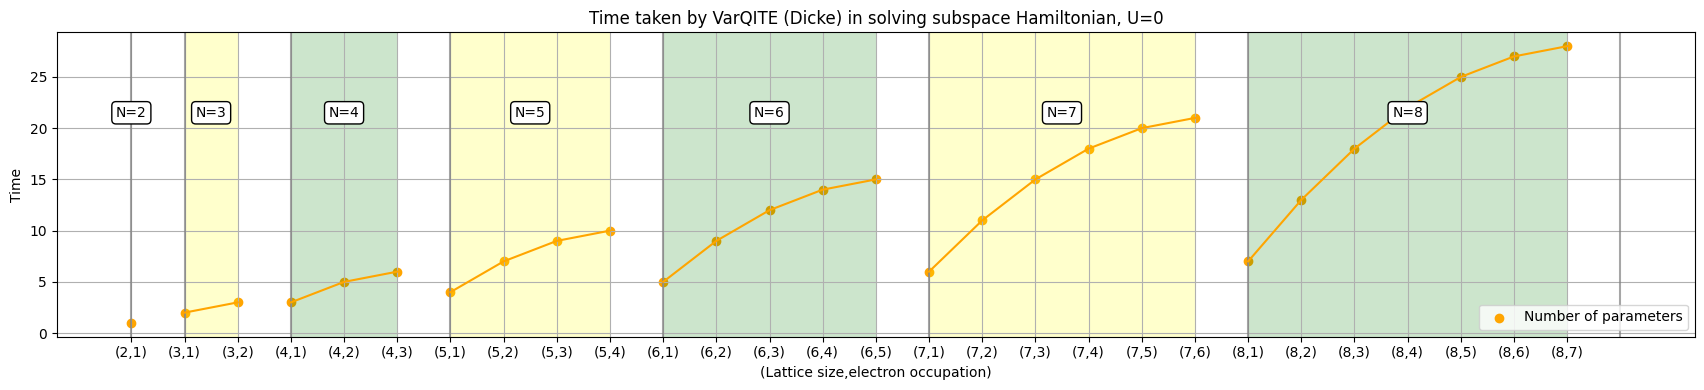

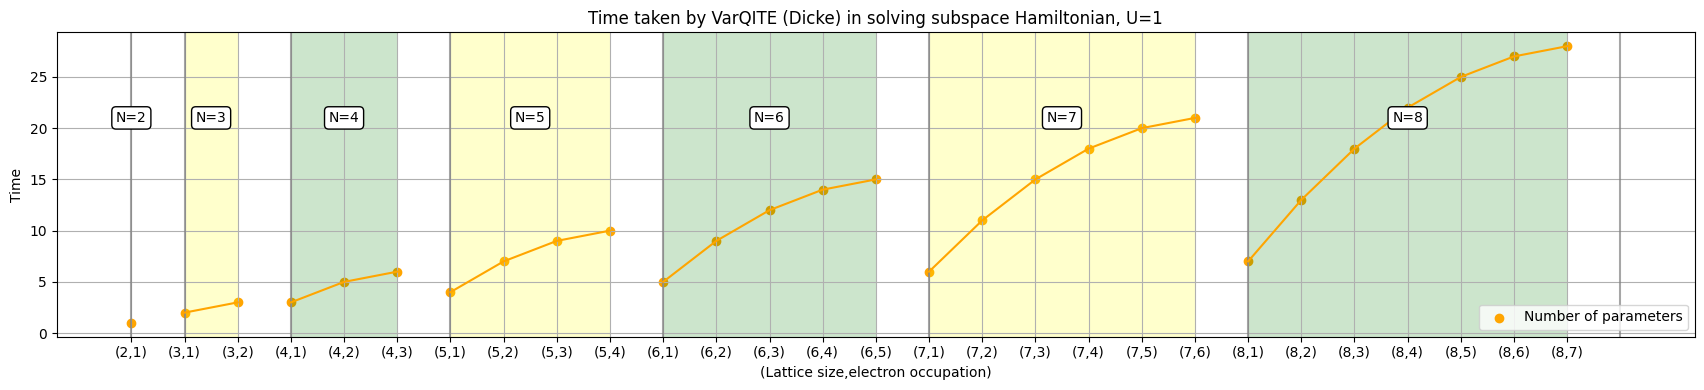

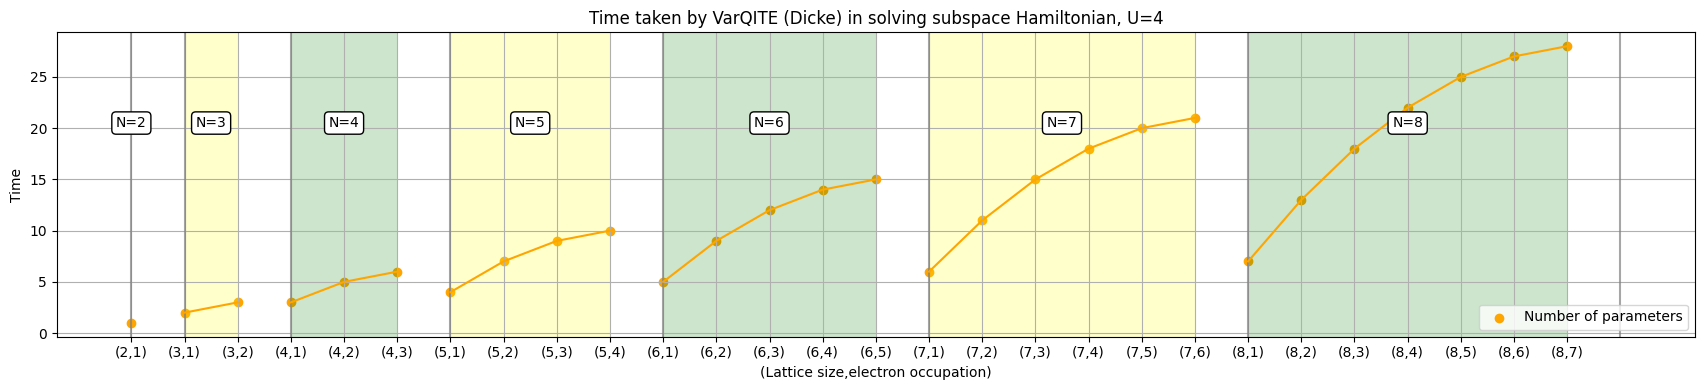

In [122]:
U = [0,1,4]

for ind,df in enumerate(df_list) : 
    fig = plt.figure(figsize=(24, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[5, 1, 1])

    time_q = df['time_q']
    #eig_true = df['eig_true']
    N = df['N']
    #xticks = [0,1,3,6,10,15]
    num_param = []
    for n in N.unique() : 
        for k in range(1,n) : 
            num_param.append(int(k*(n-k) + k*(k-1)/2))

    comb = []
    for num in df['N'].unique() : 
        sub_list = [f'({num},{i})' for i in range(1,num)]
        comb += sub_list
    #xtick_labels = [comb[i] for i in xticks]
    time_c = df['time_clas']
    time_q = df['time_q']
    
    axs0 = plt.subplot(gs[0])
    #axs0.scatter(comb, time_q, label='VarQITE (Dicke)', color='blue', marker='o')
    axs0.scatter(comb, num_param, label='Number of parameters', color='orange', marker='o')

    axs0.plot
    axs0.set_xlabel('(Lattice size,electron occupation)')
    axs0.set_ylabel('Time')
    axs0.set_title(f'Time taken by VarQITE (Dicke) in solving subspace Hamiltonian, U={U[ind]}')
    axs0.grid(True)
#     axs0.set_xticks(xticks)
#     axs0.set_xticklabels(xtick_labels)
    
    colors = ['green', 'yellow']
    partitions = [0,1,3,6,10,15,21,28]
    #partitions = [p-1 for p in partitions]
    for a in partitions:
        plt.axvline(x=a, color='gray', alpha=0.7)
    for i in range(1,len(partitions)-1) : 
        axs0.axvspan(partitions[i], partitions[i+1]-1, facecolor=colors[i%2], alpha=0.2)
#         axs0.plot(comb[partitions[i]:partitions[i+1]], time_q[partitions[i]:partitions[i+1]]
#                   , color='blue')
        axs0.plot(comb[partitions[i]:partitions[i+1]], num_param[partitions[i]:partitions[i+1]]
                  , color='orange')
    labels = [f'N={n}' for n in N.unique()]
    label_coords = []
    x = 0
    for i,n in enumerate(N.unique()) : 
        label_coords.append((partitions[i] + (n)/2-1 ,max(eig_q)-0.5*(ind+1)))
    #print(label_coords)
    for label, (x_coord, y_coord) in zip(labels, label_coords):
        axs0.text(x_coord, y_coord, label, fontsize=10, ha='center', va='center', color='black', 
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

#     for i in range(1,len(partitions)):
#         axs0.plot(partitions[i:1+i], y_values[i:i+2], linestyle='none', marker='o', markersize=8)
    axs0.legend(loc='best')
    plt.tight_layout()
    plt.show()